## Supervised Learning Methods & Models 

In this section, I will be using various supervised learning models to predict what the counts of Lymes disease will be in each region in the year 2050 under the RCP 8.5 Climate Scenario. I will compare the accuracy of the trained models to determine the optimal model, and perform my final prediction with that model. 

### Initialize Carbon Tracker 

The code below was taken from Climate Change AI's tutorial on Tracking Emissions from ML Models.

In [50]:
from codecarbon import EmissionsTracker

# Instantiate the tracker object
tracker = EmissionsTracker(
    output_dir="../data/clean_data/",  # define the directory to which we'll write our emissions results
    output_file="carbon_emissions.csv",  # define the name of the file containing our emissions results
    # log_level='error' # comment out this line to see regular output
)
tracker.start()

[codecarbon ERROR @ 17:51:22] Error: Another instance of codecarbon is probably running as we find `/var/folders/0s/3s0t3s4d31d4xtm_jt4pfhpr0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 17:51:22] Another instance of codecarbon is already running. Exiting.


In [51]:
import pandas as pd
df = pd.read_csv('../data/clean_data/data.csv')
df.columns

Index(['Year', 'Precipitation_avg', 'region', 'Min_temp_avg', 'Avg_temp',
       'State', 'Lyme_cases', 'Total_Land_Area', 'Tree_Cover_Loss',
       'species_richness', 'state_park_land_coverage', 'state_park_rank'],
      dtype='object')

## Perform supervised learning

In [52]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

### Clean data

In [53]:
def prepare_training_data(df):
    # aggregate by region with additional variables
    df_agg = df.groupby(['Year', 'region']).agg({
        'Precipitation_avg': 'first',
        'Min_temp_avg': 'first', 
        'Avg_temp': 'first',
        'Total_Land_Area': 'sum',
        'state_park_land_coverage': 'mean',
        'state_park_rank': 'mean',
        'Lyme_cases': 'sum'
    }).reset_index()
    
    X = df_agg[['Min_temp_avg', 'Avg_temp', 'Precipitation_avg', 
                'Total_Land_Area', 'state_park_land_coverage', 'state_park_rank']]
    y = df_agg['Lyme_cases']
    
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    return X, y, imputer

def prepare_future_data(future_df, imputer):
    """
    Prepare future data that's already in wide format
    """
    # The data is already in the correct format, so we just need to
    # ensure we select the correct columns in the right order
    required_columns = ['Min_temp_avg', 'Avg_temp', 'Precipitation_avg', 
                       'Total_Land_Area', 'state_park_land_coverage', 'state_park_rank']
    
    # Create a mapping dictionary for slightly different column names
    column_mapping = {
        'Min_temp': 'Min_temp_avg',
        'Avg_temp': 'Avg_temp',
        'Precipitation_avg': 'Precipitation_avg'
    }
    
    # Rename columns if needed
    future_df = future_df.rename(columns=column_mapping)
    
    # Verify all required columns are present
    missing_columns = [col for col in required_columns if col not in future_df.columns]
    if missing_columns:
        print(f"Warning: Missing columns: {missing_columns}")
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    # Create the feature matrix ensuring column order matches training data
    X_future = future_df[required_columns].values
    
    return X_future, future_df.index

### Train models

Nine supervised learning models (Linear Regression, Ridge Regression, Lasso Regression, Elastic Net, Random Forests, Gradient Boosting, AdaBoost, KNN, SVR (RBF) and Kernel Ridge) will be trained on the existing data, evaluated for their accuracy, and compared. These models were chosen in order to have a diverse range of regression and ensemble methods. 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e+08, tolerance: 4.664e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e+08, tolerance: 4.097e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+08, toler


Model Performance Metrics:

Linear Regression:
RMSE: 7423.5828
R2: 0.7478
CV_mean: 0.6778
CV_std: 0.3981

Ridge:
RMSE: 7406.3952
R2: 0.7490
CV_mean: 0.8207
CV_std: 0.1228

Lasso:
RMSE: 7424.4735
R2: 0.7477
CV_mean: 0.7023
CV_std: 0.3505

Random Forest:
RMSE: 8817.0269
R2: 0.6442
CV_mean: 0.8771
CV_std: 0.0593

Gradient Boosting:
RMSE: 10596.6941
R2: 0.4861
CV_mean: 0.8167
CV_std: 0.0525

AdaBoost:
RMSE: 11405.0893
R2: 0.4047
CV_mean: 0.8392
CV_std: 0.0886

KNN:
RMSE: 9747.6350
R2: 0.5652
CV_mean: 0.8890
CV_std: 0.0714

SVR (RBF):
RMSE: 19782.2224
R2: -0.7908
CV_mean: -0.4084
CV_std: 0.3519

Kernel Ridge:
RMSE: 9060.9966
R2: 0.6243
CV_mean: 0.8958
CV_std: 0.0366


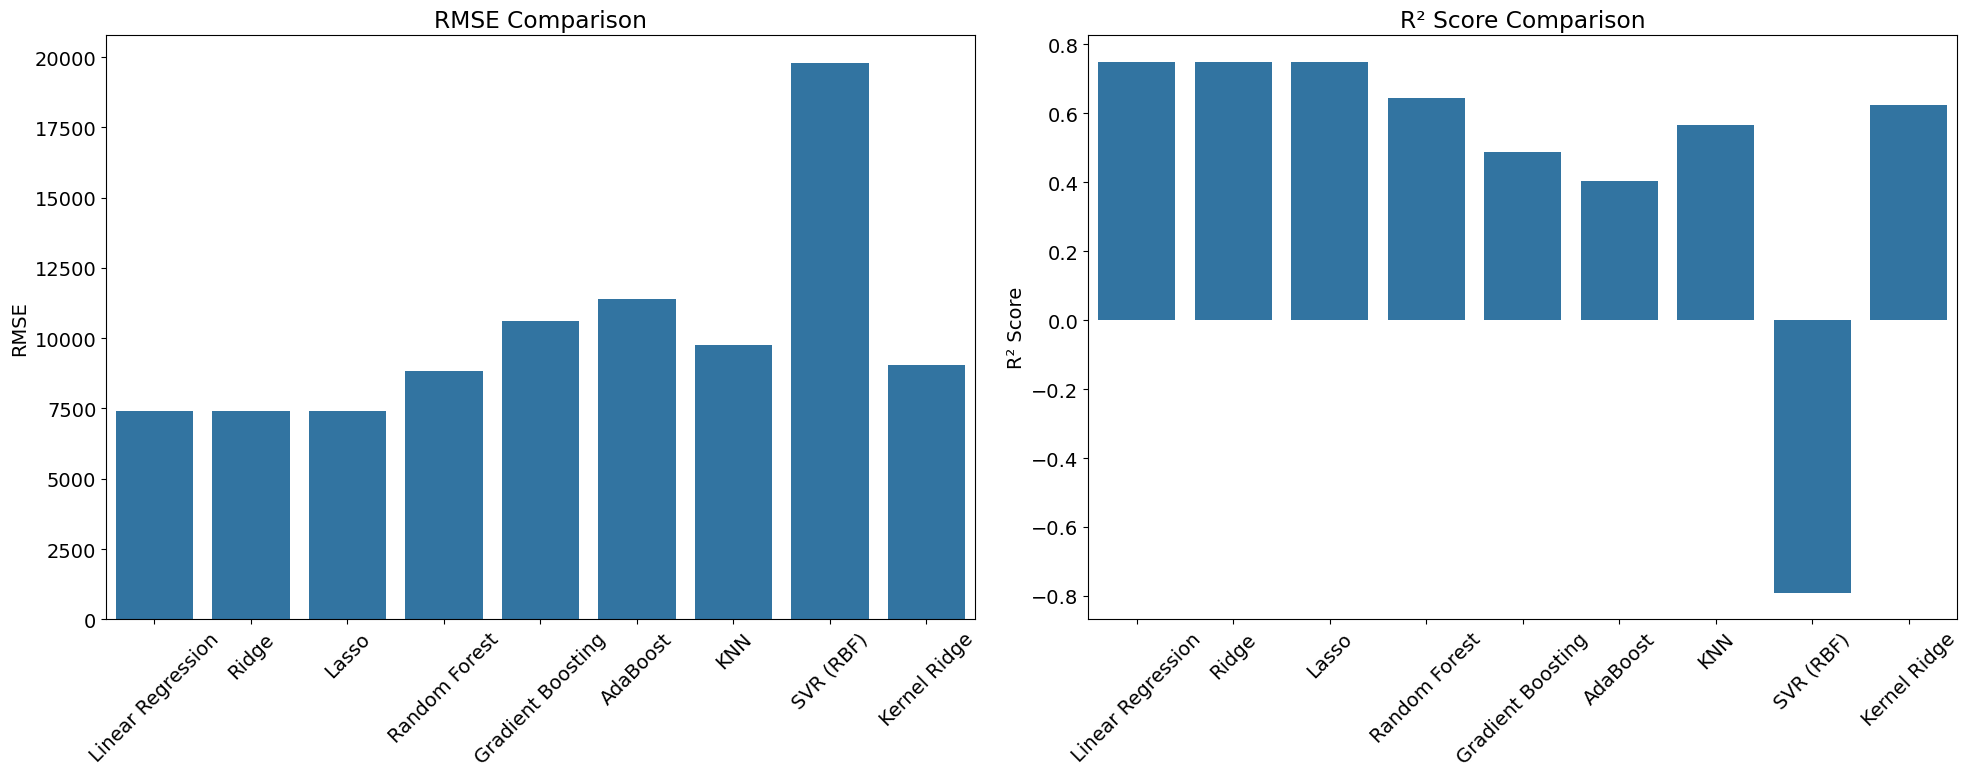

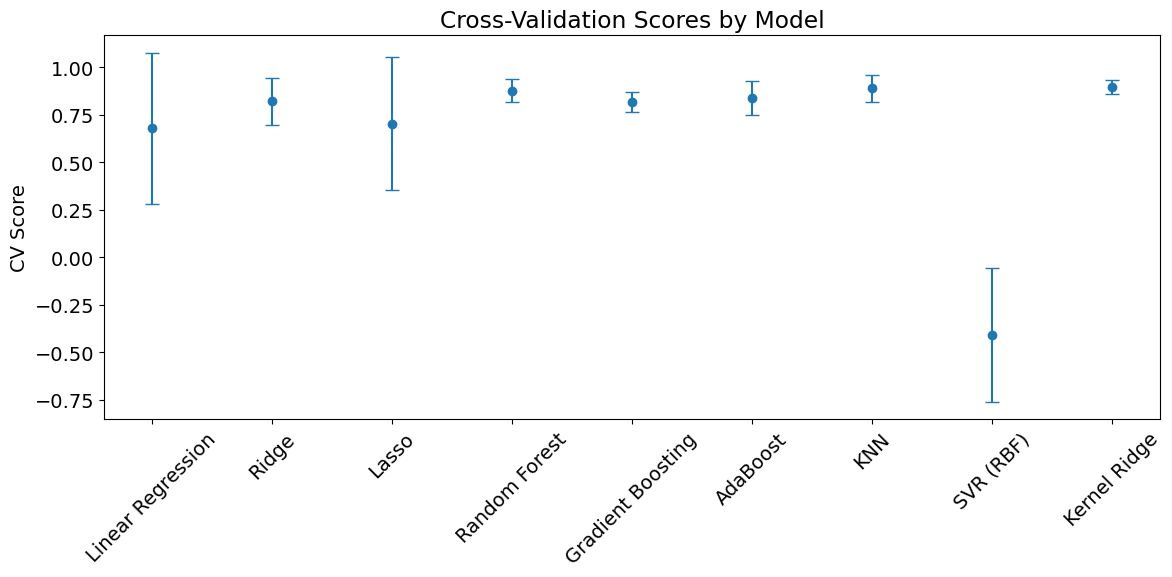

In [54]:

def train_and_evaluate_models(X, y):
   # Split the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
   # Scale the features
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)
   
   # initialize selected models 
   models = {
       'Linear Regression': LinearRegression(),
       'Ridge': Ridge(alpha=0.1),
       'Lasso': Lasso(alpha=0.1),
       'Random Forest': RandomForestRegressor(n_estimators=200, min_samples_leaf=2),
       'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1),
       'AdaBoost': AdaBoostRegressor(n_estimators=200),
       'KNN': KNeighborsRegressor(n_neighbors=3),
       'SVR (RBF)': SVR(kernel='rbf', C=10),
       'Kernel Ridge': KernelRidge(kernel='rbf', alpha=0.1)
   }
   
   # Train and evaluate models
   results = {}
   trained_models = {}
   
   for name, model in models.items():
       try:
           # Train model
           model.fit(X_train_scaled, y_train)
           
           # Make predictions
           y_pred = model.predict(X_test_scaled)
           
           # Calculate metrics
           mse = mean_squared_error(y_test, y_pred)
           rmse = np.sqrt(mse)
           r2 = r2_score(y_test, y_pred)
           
           # Perform cross-validation
           cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
           
           results[name] = {
               'RMSE': rmse,
               'R2': r2,
               'CV_mean': cv_scores.mean(),
               'CV_std': cv_scores.std()
           }
           trained_models[name] = model
           
       except Exception as e:
           print(f"Error training {name}: {str(e)}")
   
   return results, trained_models, scaler


# Function to visualize the RMSE and R^2 of each model for comparison of accuracy 
def plot_model_comparison(results):

   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
   
   # Prepare data 
   models = list(results.keys())
   rmse_scores = [results[model]['RMSE'] for model in models]
   r2_scores = [results[model]['R2'] for model in models]
   
   # RMSE comparison
   sns.barplot(x=models, y=rmse_scores, ax=ax1)
   ax1.set_title('RMSE Comparison')
   ax1.set_ylabel('RMSE')
   ax1.tick_params(axis='x', rotation=45)
   
   # R^2 comparison
   sns.barplot(x=models, y=r2_scores, ax=ax2)
   ax2.set_title('R² Score Comparison')
   ax2.set_ylabel('R² Score')
   ax2.tick_params(axis='x', rotation=45)
   
   plt.tight_layout()
   return fig

# Function to compare the cross validation of the models
def plot_cross_validation_results(results):
   fig, ax = plt.subplots(figsize=(12, 6))
   
   models = list(results.keys())
   cv_means = [results[model]['CV_mean'] for model in models]
   cv_stds = [results[model]['CV_std'] for model in models]
   
   # CV scores with error bars
   ax.errorbar(models, cv_means, yerr=cv_stds, fmt='o', capsize=5)
   ax.set_title('Cross-Validation Scores by Model')
   ax.set_ylabel('CV Score')
   plt.xticks(rotation=45)
   plt.tight_layout()
   
   return fig

# Main execution
if __name__ == "__main__":

   hist_df = pd.read_csv('../data/clean_data/data.csv')
   future_df = pd.read_csv('../data/clean_data/2050inputs.csv')
   
   X, y, imputer = prepare_training_data(hist_df)
   
   # apply training and evaluation function to data
   results, trained_models, scaler = train_and_evaluate_models(X, y)
   
   print("\nModel Performance Metrics:")
   for model_name, metrics in results.items():
       print(f"\n{model_name}:")
       for metric_name, value in metrics.items():
           print(f"{metric_name}: {value:.4f}")
   
   # plot comparisons
   comparison_fig = plot_model_comparison(results)
   cv_fig = plot_cross_validation_results(results)
   
   # Prepare and predict with 2050 data
   future_X, future_regions = prepare_future_data(future_df, imputer)
   future_X_scaled = scaler.transform(future_X)

The regression models (Linear, Ridge, and Lasso) have the lowest RMSE and highest R^2. However, their cross-validation scores are more inconsistent. 

### Make predictions using 2050 inputs

In [55]:

# Make predictions for 2050 with each model
print("\nPredicted Lyme Disease Cases for 2050 by Region:")
for model_name, model in trained_models.items():
    predictions = model.predict(future_X_scaled)
    print(f"\n{model_name} predictions:")
    for region, pred in zip(future_regions, predictions):
        print(f"{region}: {max(0, int(pred))} cases")


Predicted Lyme Disease Cases for 2050 by Region:

Linear Regression predictions:
0: 0 cases
1: 14330 cases
2: 0 cases
3: 0 cases

Ridge predictions:
0: 0 cases
1: 7538 cases
2: 0 cases
3: 0 cases

Lasso predictions:
0: 0 cases
1: 14470 cases
2: 0 cases
3: 0 cases

Random Forest predictions:
0: 5650 cases
1: 13821 cases
2: 2482 cases
3: 1293 cases

Gradient Boosting predictions:
0: 5182 cases
1: 9453 cases
2: 2239 cases
3: 1969 cases

AdaBoost predictions:
0: 4852 cases
1: 22215 cases
2: 3561 cases
3: 2966 cases

KNN predictions:
0: 195 cases
1: 20998 cases
2: 4173 cases
3: 195 cases

SVR (RBF) predictions:
0: 2387 cases
1: 2387 cases
2: 2387 cases
3: 2387 cases

Kernel Ridge predictions:
0: 0 cases
1: 87 cases
2: 0 cases
3: 0 cases


## Comparison of outputs

The cells below visualize the comparison of the true regional case counts in 2019 (this year was chosen so that the effect of COVID would not impact the counts) to the case counts predicted by each model. 

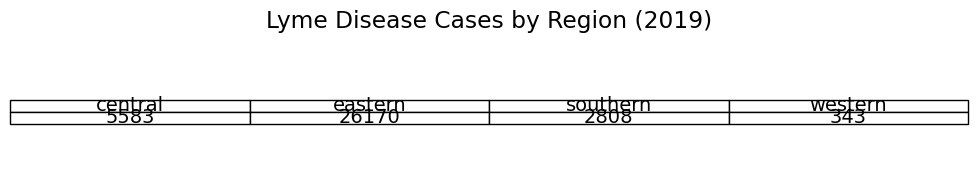

In [56]:
# create table of 2019 counts per region

hist_2019 = hist_df[hist_df['Year'] == 2019].groupby('region')['Lyme_cases'].sum()

plt.figure(figsize=(10, 2))

table_data = [hist_2019.values]
table_cols = hist_2019.index

plt.table(cellText=table_data,
          colLabels=table_cols,
          cellLoc='center',
          loc='center',
          edges='closed')

plt.axis('off')
plt.title('Lyme Disease Cases by Region (2019)', pad=20)
plt.tight_layout()
plt.show()



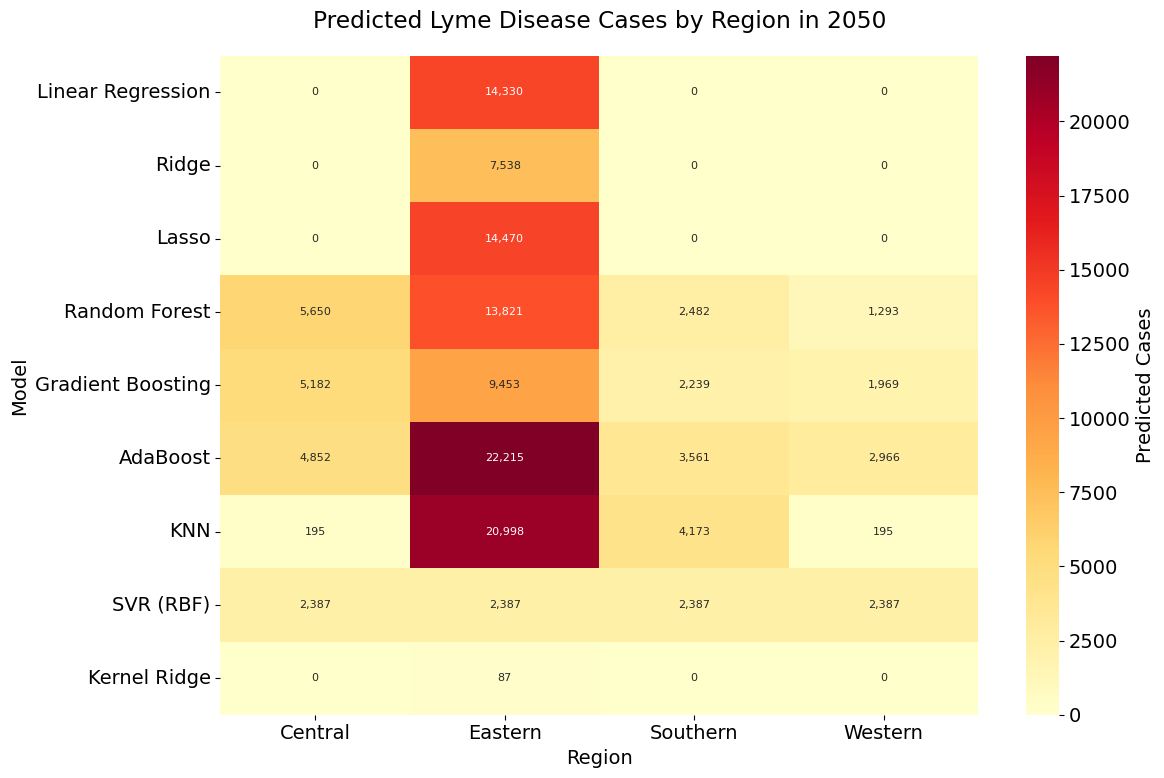

In [57]:
# Heatmap of predicted Lyme cases per region by every model 

def create_predictions_heatmap(trained_models, future_X_scaled, future_regions):

    predictions = {}
    
    # Get predictions for each model
    for model_name, model in trained_models.items():
        preds = model.predict(future_X_scaled)
        predictions[model_name] = [max(0, int(pred)) for pred in preds]
    
    df = pd.DataFrame(predictions, 
                     index=['Central', 'Eastern', 'Southern', 'Western']).T
    
    plt.figure(figsize=(12, 8))
    
    # Create heatmap
    sns.heatmap(df, annot=True, fmt=',d', cmap='YlOrRd',
                cbar_kws={'label': 'Predicted Cases'},
                annot_kws={'size': 8})
    
    plt.title('Predicted Lyme Disease Cases by Region in 2050', pad=20)
    plt.ylabel('Model')
    plt.xlabel('Region')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return plt.gcf()

fig = create_predictions_heatmap(trained_models, future_X_scaled, future_regions)
plt.show()

Despite having the lowest RMSE and highest R^2, the regression models perform poorly because they each output zeros for three regions. Kernel Ridge and SVR (RBF) also perform problematically -- the former has the same problem as the regression models (but its eastern estimation is even lower), and the latter predicts the same value for each region. Therefore, we will continue forward comparing the remaining ensemble methods-- Random Forests, Gradient Boosting, AdaBoost and KNN -- against the existing data's true results. 

/var/folders/0s/3s0t3s4d31d4xtm_jt4pfhpr0000gn/T/ipykernel_71702/751221423.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  '2019 Actual': [hist_data.get(region, 0) for region in region_order],



Detailed Regional Comparison:
          2019 Actual  2050 Random Forest  2050 Gradient Boosting  2050 AdaBoost  2050 KNN  Random Forest % Change  Gradient Boosting % Change  AdaBoost % Change  KNN % Change
Central          5583              5650.4                  5182.5         4852.8     195.7                     1.2                        -7.2              -13.1         -96.5
Eastern         26170             13821.5                  9453.6        22215.0   20998.3                   -47.2                       -63.9              -15.1         -19.8
Southern         2808              2483.0                  2239.9         3561.2    4173.3                   -11.6                       -20.2               26.8          48.6
Western           343              1293.7                  1969.1         2966.0     195.7                   277.2                       474.1              764.7         -43.0


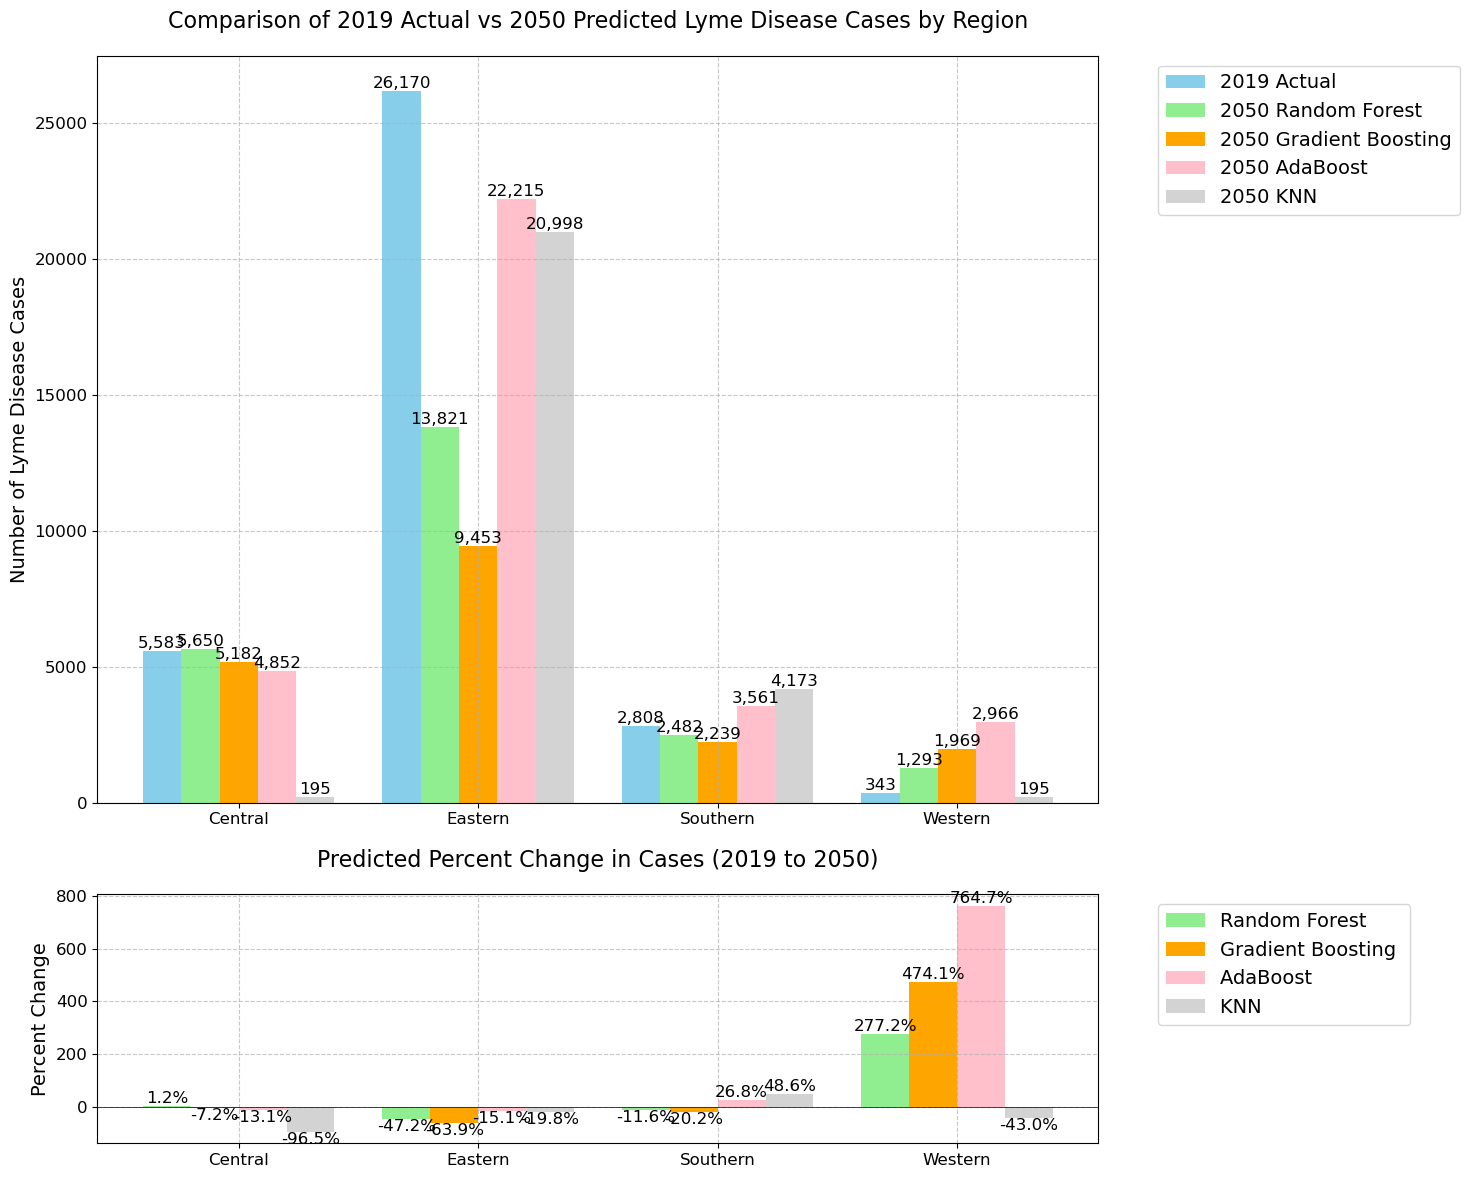

In [58]:
# Function that compares 2019 actual counts to 2050 predictions of Random Forests, Gradient Boosting, AdaBoost and KNN

def plot_multiple_models_comparison(hist_df, future_regions, predictions_dict, year_to_compare=2019):
    # mapping between indices and region names
    region_mapping = {
        0: 'Central',
        1: 'Eastern', 
        2: 'Southern',
        3: 'Western'
    }
    
    # order
    region_order = [0, 1, 2, 3]  # central, eastern, southern, western
    
    # isolate 2019 data
    hist_data = hist_df[hist_df['Year'] == year_to_compare].groupby('region')['Lyme_cases'].sum()
    comparison_df = pd.DataFrame({
        '2019 Actual': [hist_data.get(region, 0) for region in region_order],
    }, index=[region_mapping[i] for i in region_order])
    
    # Add predictions for each model
    for model_name, predictions in predictions_dict.items():
        # Create a mapping of original indices to predictions
        pred_dict = dict(zip(future_regions, predictions))
        # Add predictions in the desired order
        comparison_df[f'2050 {model_name}'] = [pred_dict[region] for region in region_order]
    
    # Calculate percent changes for each model
    base_values = comparison_df['2019 Actual']
    for model_name in predictions_dict.keys():
        pred_col = f'2050 {model_name}'
        comparison_df[f'{model_name} % Change'] = (
            (comparison_df[pred_col] - base_values) / base_values * 100
        )
    
    # font sizes
    plt.rcParams.update({'font.size': 14})
    TITLE_SIZE = 16
    LABEL_SIZE = 14
    TICK_SIZE = 12
    BAR_LABEL_SIZE = 12
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[3, 1])
    
    # Bar plot
    x = np.arange(len(region_order))
    width = 0.16 
    
    # Colors
    colors = ['skyblue', 'lightgreen', 'orange', 'pink', 'lightgray']
    
    # Plot bars for actual and each model
    bars_list = []
    labels = ['2019 Actual'] + [f'2050 {model}' for model in predictions_dict.keys()]
    
    for i, column in enumerate(labels):
        position = x + (i - len(labels)/2 + 0.5) * width
        bars = ax1.bar(position, comparison_df[column], width, 
                      label=column, color=colors[i])
        bars_list.append(bars)
        
        # Value labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom',
                    fontsize=BAR_LABEL_SIZE)
    
    # First plot customization
    ax1.set_ylabel('Number of Lyme Disease Cases', fontsize=LABEL_SIZE)
    ax1.set_title('Comparison of 2019 Actual vs 2050 Predicted Lyme Disease Cases by Region', 
                  fontsize=TITLE_SIZE, pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=TICK_SIZE)
    ax1.tick_params(axis='y', labelsize=TICK_SIZE)
    ax1.legend(fontsize=LABEL_SIZE, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Percent change plot
    percent_change_cols = [col for col in comparison_df.columns if '% Change' in col]
    width = 0.2 
    
    for i, col in enumerate(percent_change_cols):
        position = x + (i - len(percent_change_cols)/2 + 0.5) * width
        bars = ax2.bar(position, comparison_df[col], width,
                      label=col.replace('% Change', ''),
                      color=colors[i+1])
        
        # Add percent change labels
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.1f}%',
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=BAR_LABEL_SIZE)
    
    ax2.set_ylabel('Percent Change', fontsize=LABEL_SIZE)
    ax2.set_title('Predicted Percent Change in Cases (2019 to 2050)', 
                  fontsize=TITLE_SIZE, pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=TICK_SIZE)
    ax2.tick_params(axis='y', labelsize=TICK_SIZE)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.legend(fontsize=LABEL_SIZE, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig, comparison_df

# Get predictions for each model
predictions_dict = {
    'Random Forest': trained_models['Random Forest'].predict(future_X_scaled),
    'Gradient Boosting': trained_models['Gradient Boosting'].predict(future_X_scaled),
    'AdaBoost': trained_models['AdaBoost'].predict(future_X_scaled),
    'KNN': trained_models['KNN'].predict(future_X_scaled)
}

# Create the visualization
comparison_fig, comparison_data = plot_multiple_models_comparison(
    hist_df,
    future_regions,
    predictions_dict
)

# Print the numerical comparison
print("\nDetailed Regional Comparison:")
print(comparison_data.round(1).to_string())
plt.show()

# Carbon Emissions Tracking Results

In [ ]:

emissions = tracker.stop()
if emissions is not None:
    print(f"Emissions from this training run: {emissions:5f} kg CO2eq")
else:
    print("No emissions data available")

[codecarbon WARNING @ 17:51:36] Another instance of codecarbon is already running. Exiting.


No emissions data available


[codecarbon INFO @ 17:51:38] Energy consumed for RAM : 0.001997 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:51:38] Energy consumed for all CPUs : 0.003329 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 17:51:38] 0.005326 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:38] 0.000485 g.CO2eq/s mean an estimation of 15.297008329355881 kg.CO2eq/year
